In [1]:
#기본
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import FinanceDataReader as fdr
import mglearn
import sklearn

#분류 모델
from sklearn.svm import LinearSVC
from sklearn import neighbors,svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
#스케일러
from sklearn.preprocessing import MinMaxScaler

#성과 평가
from sklearn.metrics import confusion_matrix #오차행렬
from sklearn.metrics import accuracy_score #정확도
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [31]:
#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_3=df["Close"].rolling(3).mean()
    MA_5=df["Close"].rolling(5).mean()
    df=df.assign(MA_10=MA_10,MA_60=MA_60).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df
   
    #시간
def get_time(df):
    time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)
    
    return df

In [3]:
# Methods

#train_test_split, score 도출----------------------

def print_score(X,y,model):
    
    setlen=int(round(len(X)*0.7,0))
    y=y.astype('int')
    X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]

    reg=model.fit(X_train,y_train)
    print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
    print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

    confusion=confusion_matrix(y_test,reg.predict(X_test))
    print(confusion)
    
    


#미래 예측을 위한 시간조정-------------------   

def adjust_time(X,y):
    y=pd.DataFrame(np.array(y),index=X.index).shift(-1).dropna()
    X=X.loc[y.index].dropna()
    
    return X,y


In [4]:

RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:


KS=fdr.DataReader("HSI","1990-01-01","2019-08-14")

#특성 추가---
KS=get_stochastic(KS)
KS=get_time(KS)

X=KS
#--------
MA_3=KS["Close"].rolling(3).mean()
MA_5=KS["Close"].rolling(5).mean()
MA_10=KS["Close"].rolling(10).mean()
MA_20=KS["Close"].rolling(20).mean()
MA_30=KS["Close"].rolling(30).mean()
malist=[MA_60,MA_90,MA_120,MA_180,MA_360]
KS_MA=KS.assign(MA_60=MA_60,MA_90=MA_90,MA_120=MA_120,MA_180=MA_180,MA_360=MA_360).dropna()


HSI


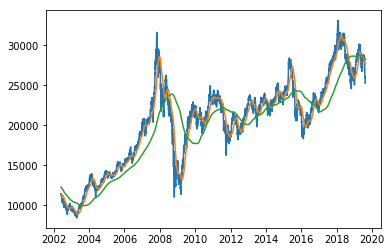

In [6]:


plt.plot(KS_MA.index,KS_MA["Close"])
plt.plot(KS_MA.index,KS_MA["MA_60"])
plt.plot(KS_MA.index,KS_MA["MA_360"])
print("HSI")

MA_60


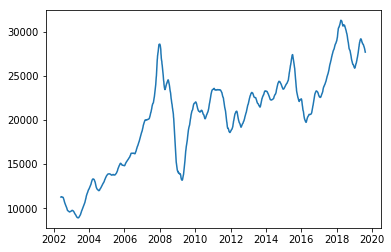

In [7]:
plt.plot(KS_MA.index,KS_MA["MA_60"])
print("MA_60")

MA_360


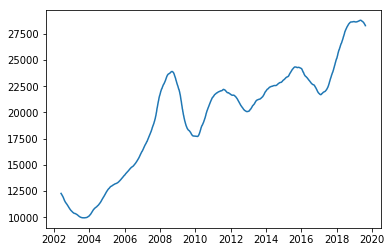

In [8]:
plt.plot(KS_MA.index,KS_MA["MA_360"])
print("MA_360")

In [129]:
def cross_score(X,y,SC):
    print("\n교차검증 테스트------")
    len1=int(round(len(X)*1/5,0))
    len2=int(round(len1*4/5,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score1=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score1=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    len1=int(round(len(X)*2/5,0))
    len2=int(round(len1*9/10,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score2=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score2=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    len1=int(round(len(X)*3/5,0))
    len2=int(round(len1*14/15,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score3=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score3=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    len1=int(round(len(X)*4/5,0))
    len2=int(round(len1*19/20,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score4=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score4=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    len1=int(round(len(X)*5/5,0))
    len2=int(round(len1*24/25,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score5=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score5=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    X_train_score=(train_score1+train_score2+train_score3+train_score4+train_score5)/5
    X_test_score=(test_score1+test_score2+test_score3+test_score4+test_score5)/5
    print("  score 1 :",test_score1,",""\n","score 2 :",test_score2,",""\n","score 3 :",test_score3,",""\n","score 4 :",test_score4,",""\n","score 5 :",test_score5,",""\n")
    print("교차검증 훈련 점수 : ",X_train_score,"\n교차검증 테스트 점수 : ",X_test_score)
    SC.append("훈련 교차 :%s, 테스트 교차 : %s" %(X_train_score,X_test_score))


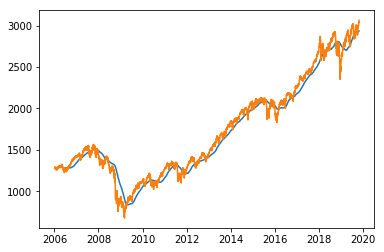

In [24]:
euro=fdr.DataReader("US500","1990-01-01")
MA_120=euro["Close"].rolling(120).mean()
plt.plot(euro.index,MA_120)
plt.plot(euro.index,euro["Close"])

In [152]:
import warnings
warnings.filterwarnings(action='ignore') 


SC=[]
for y in ["US500","RSTI","EURO","HSI"]:
    SC.append(y)
    print("\n",y,"-------------")
    
    KS=fdr.DataReader(y,"1990-01-01","2019-10-01")
    KS=get_stochastic(KS)
    KS=get_time(KS)
    
    
    MA_3=KS["Close"].rolling(3).mean().dropna()
    MA_5=KS["Close"].rolling(5).mean().dropna()
    MA_10=KS["Close"].rolling(10).mean().dropna()
    MA_20=KS["Close"].rolling(20).mean().dropna()
    MA_30=KS["Close"].rolling(30).mean().dropna()
    malist=[MA_3,MA_5,MA_10,MA_20,MA_30]
    malist2=["MA_3","MA_5","MA_10","MA_20","MA_30"]
    KS=KS.assign(MA_3=MA_3,MA_5=MA_5,MA_10=MA_10,MA_20=MA_20,MA_30=MA_30).dropna()
    n=0
    score_list=[]
        
    for x in malist:
        KS[malist2[n]]=x
        KS=KS.dropna()
        
        y=np.where(KS["Close"]>KS[malist2[n]],1,0)
        X,y=adjust_time(KS,y)

        setlen=int(round(len(X)*0.7,0))
        y=y.astype('int')
        X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]
        print(malist2[n])
        
        print_score(X,y,RandomForestClassifier(random_state=2))
        SC.append(malist2[n])
        cross_score(X,y,SC)
        n=n+1


 US500 -------------
MA_3
훈련 세트 정확도:0.980
테스트 세트 정확도:0.516
[[373  68]
 [430 157]]

교차검증 테스트------
  score 1 : 0.49635036496350365 ,
 score 2 : 0.5328467153284672 ,
 score 3 : 0.5109489051094891 ,
 score 4 : 0.5109489051094891 ,
 score 5 : 0.48905109489051096 ,

교차검증 훈련 점수 :  0.9771114047411877 
교차검증 테스트 점수 :  0.5080291970802919
MA_5
훈련 세트 정확도:0.983
테스트 세트 정확도:0.473
[[370  52]
 [490 116]]

교차검증 테스트------
  score 1 : 0.5547445255474452 ,
 score 2 : 0.7226277372262774 ,
 score 3 : 0.36496350364963503 ,
 score 4 : 0.5182481751824818 ,
 score 5 : 0.6277372262773723 ,

교차검증 훈련 점수 :  0.9834669942434674 
교차검증 테스트 점수 :  0.5576642335766423
MA_10
훈련 세트 정확도:0.986
테스트 세트 정확도:0.523
[[325  40]
 [450 213]]

교차검증 테스트------
  score 1 : 0.6861313868613139 ,
 score 2 : 0.7226277372262774 ,
 score 3 : 0.6204379562043796 ,
 score 4 : 0.6058394160583942 ,
 score 5 : 0.781021897810219 ,

교차검증 훈련 점수 :  0.9862787363694198 
교차검증 테스트 점수 :  0.6832116788321168
MA_20
훈련 세트 정확도:0.990
테스트 세트 정확도:0.428
[[304  27]
 [56

In [146]:
SC

['US500',
 'MA_3',
 '훈련 교차 :0.9806166382819235, 테스트 교차 : 0.5217391304347826',
 'MA_5',
 '훈련 교차 :0.9844181886912967, 테스트 교차 : 0.6695652173913044',
 'MA_10',
 '훈련 교차 :0.9802096810137918, 테스트 교차 : 0.7130434782608696',
 'MA_20',
 '훈련 교차 :0.9899691905749247, 테스트 교차 : 0.7751613244472655',
 'MA_30',
 '훈련 교차 :0.9919466836106265, 테스트 교차 : 0.751824817518248',
 'RSTI',
 'MA_3',
 '훈련 교차 :0.9819782135897336, 테스트 교차 : 0.5703703703703704',
 'MA_5',
 '훈련 교차 :0.9858885770425776, 테스트 교차 : 0.6074074074074074',
 'MA_10',
 '훈련 교차 :0.9850407474715981, 테스트 교차 : 0.7074074074074074',
 'MA_20',
 '훈련 교차 :0.9917691748463222, 테스트 교차 : 0.8314814814814815',
 'MA_30',
 '훈련 교차 :0.9926320693944595, 테스트 교차 : 0.8299065420560747',
 'EURO',
 'MA_3',
 '훈련 교차 :0.9764199546709481, 테스트 교차 : 0.5428571428571429',
 'MA_5',
 '훈련 교차 :0.9784288270865362, 테스트 교차 : 0.5964285714285714',
 'MA_10',
 '훈련 교차 :0.9793366528498456, 테스트 교차 : 0.6535714285714285',
 'MA_20',
 '훈련 교차 :0.9852449150292557, 테스트 교차 : 0.7381818181818183',
 'MA_30',
 '훈

Text(0.5,1,'HSI')

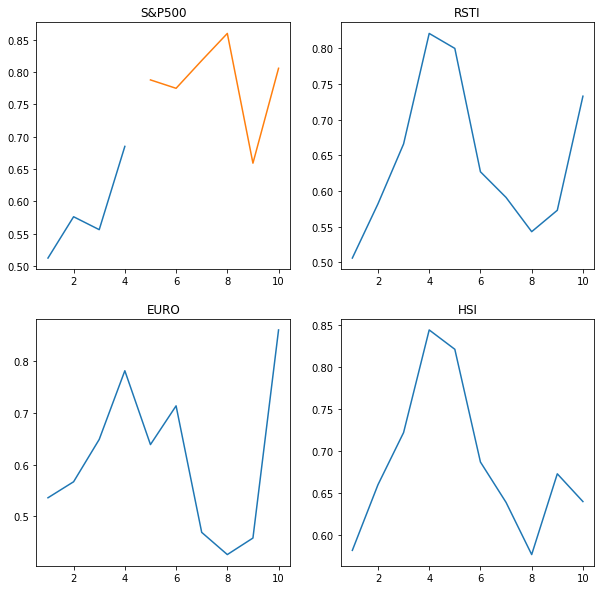

In [143]:
x=np.linspace(1,10,10)
us=[0.512,0.576,0.556,0.685,0.788,0.775,0.818,0.860,0.659,0.806]
rsti=[0.506,0.582,0.666,0.821,0.8,0.627,0.591,0.543,0.573,0.733]
euro=[0.536,0.567,0.649,0.782,0.639,0.714,0.469,0.426,0.458,0.861]
hsi=[0.582,0.66,0.722,0.844,0.821,0.687,0.639,0.577,0.673,0.64]
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2,figsize=(10,10))
axes[0,0].plot(x[:4],us[:4])
axes[0,0].plot(x[4:],us[4:])
axes[0,0].set_title("S&P500")
axes[0,1].plot(x,rsti)
axes[0,1].set_title("RSTI")
axes[1,0].plot(x,euro)
axes[1,0].set_title("EURO")
axes[1,1].plot(x,hsi)
axes[1,1].set_title("HSI")

In [151]:
SC=[]
for y in ["US500","RSTI","EURO","HSI"]:
    SC.append(y)
    print("\n",y,"-------------")
    
    KS=fdr.DataReader(y,"1990-01-01","2019-10-01")
    KS=get_stochastic(KS)
    KS=get_time(KS)
    
    
    MA_3=KS["Close"].rolling(3).mean().dropna()
    MA_5=KS["Close"].rolling(5).mean().dropna()
    MA_10=KS["Close"].rolling(10).mean().dropna()
    MA_20=KS["Close"].rolling(20).mean().dropna()
    MA_30=KS["Close"].rolling(30).mean().dropna()
    malist=[MA_3,MA_5,MA_10,MA_20,MA_30]
    malist2=["MA_3","MA_5","MA_10","MA_20","MA_30",]
    n=0
    score_list=[]
    KS=KS.assign(MA_60=MA_60,MA_90=MA_90,MA_120=MA_120,MA_180=MA_180,MA_360=MA_360).dropna()
        
    for x in malist:
        KS[malist2[n]]=x
        KS=KS.dropna()
        
        y=np.where(KS["Change"]>0,1,0)
        X,y=adjust_time(KS,y)

        setlen=int(round(len(X)*0.7,0))
        y=y.astype('int')
        X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]
        print_score(X,y,RandomForestClassifier(random_state=2))
        SC.append(malist2[n])
        cross_score(X,y,SC)
        n=n+1


 US500 -------------
훈련 세트 정확도:0.972
테스트 세트 정확도:0.501
[[137  50]
 [150  64]]

교차검증 테스트------
  score 1 : 0.5094339622641509 ,
 score 2 : 0.5849056603773585 ,
 score 3 : 0.5283018867924528 ,
 score 4 : 0.6037735849056604 ,
 score 5 : 0.5283018867924528 ,

교차검증 훈련 점수 :  0.9747587830274872 
교차검증 테스트 점수 :  0.5509433962264151
훈련 세트 정확도:0.973
테스트 세트 정확도:0.504
[[  8 179]
 [ 20 194]]

교차검증 테스트------
  score 1 : 0.5283018867924528 ,
 score 2 : 0.49056603773584906 ,
 score 3 : 0.4716981132075472 ,
 score 4 : 0.5283018867924528 ,
 score 5 : 0.5283018867924528 ,

교차검증 훈련 점수 :  0.9766128928575538 
교차검증 테스트 점수 :  0.5094339622641508
훈련 세트 정확도:0.976
테스트 세트 정확도:0.499
[[ 60 127]
 [ 74 140]]

교차검증 테스트------
  score 1 : 0.49056603773584906 ,
 score 2 : 0.6037735849056604 ,
 score 3 : 0.5094339622641509 ,
 score 4 : 0.5849056603773585 ,
 score 5 : 0.5471698113207547 ,

교차검증 훈련 점수 :  0.9774777817355623 
교차검증 테스트 점수 :  0.5471698113207547
훈련 세트 정확도:0.978
테스트 세트 정확도:0.494
[[ 86 101]
 [102 112]]

교차검증 테스트-----

In [153]:
SC

['US500',
 'MA_3',
 '훈련 교차 :0.9771114047411877, 테스트 교차 : 0.5080291970802919',
 'MA_5',
 '훈련 교차 :0.9834669942434674, 테스트 교차 : 0.5576642335766423',
 'MA_10',
 '훈련 교차 :0.9862787363694198, 테스트 교차 : 0.6832116788321168',
 'MA_20',
 '훈련 교차 :0.991555588015674, 테스트 교차 : 0.7766423357664234',
 'MA_30',
 '훈련 교차 :0.9919466836106265, 테스트 교차 : 0.751824817518248',
 'RSTI',
 'MA_3',
 '훈련 교차 :0.9826656955805788, 테스트 교차 : 0.5663551401869158',
 'MA_5',
 '훈련 교차 :0.9843315245553026, 테스트 교차 : 0.6878504672897197',
 'MA_10',
 '훈련 교차 :0.9870137293323247, 테스트 교차 : 0.6766355140186915',
 'MA_20',
 '훈련 교차 :0.9920116736122842, 테스트 교차 : 0.8485981308411216',
 'MA_30',
 '훈련 교차 :0.9926320693944595, 테스트 교차 : 0.8299065420560747',
 'EURO',
 'MA_3',
 '훈련 교차 :0.9775826520541233, 테스트 교차 : 0.5163636363636364',
 'MA_5',
 '훈련 교차 :0.9775877799608823, 테스트 교차 : 0.5890909090909091',
 'MA_10',
 '훈련 교차 :0.9834043325096797, 테스트 교차 : 0.6872727272727273',
 'MA_20',
 '훈련 교차 :0.9911487183098229, 테스트 교차 : 0.7818181818181819',
 'MA_30',
 '훈련

In [14]:

reg1=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
reg2=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
reg3=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
reg4=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)

precision,recall,thresholds=precision_recall_curve(y_test,reg4.decision_function(X_test))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y w

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y w

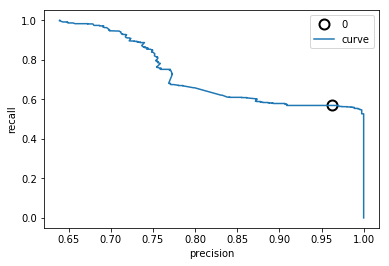

In [15]:

reg1=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
reg2=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
reg3=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
reg4=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)

precision,recall,thresholds=precision_recall_curve(y_test,reg4.decision_function(X_test))

close_zero=np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero],recall[close_zero],'o',markersize=10,label='0',fillstyle="none",c='k',mew=2)
plt.plot(precision,recall,label="curve")
plt.xlabel("precision")
plt.ylabel('recall')
plt.legend(loc="best")


NameError: name 'close_default_rf' is not defined

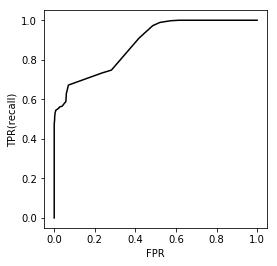

In [16]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(4, 4))
fpr_rf,tpr_rf,thresholds_rf=roc_curve(y_test,reg3.predict_proba(X_test)[:,1])

plt.plot(fpr_rf,tpr_rf,'k')
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.plot(fpr_rf[close_default_rf],tpr_rf[close_default_rf],'^',markersize=10,label="RF recall : 0.5",fillstyle="none",mew=2)


In [ ]:
X

In [ ]:
plt.plot(X.index,X["Close"])
plt.plot(X.index,X["MA_60"],'k')

In [ ]:
y

In [ ]:
plt.plot(X.index,X["Close"])

In [ ]:
plt.plot(X.index[:int(round(len(X.index)*0.8,0))],X["Close"][:int(round(len(X.index)*0.8,0))])
plt.plot(X.index[int(round(len(X.index)*0.8,0)):],X["Close"][int(round(len(X.index)*0.8,0)):])

plt.title("IXIC")

In [ ]:
X

In [ ]:
len(X)-setlen

In [ ]:
len(X_test)

In [ ]:
setlen=int(round(len(X)*0.7,0))

In [ ]:
len(X)-setlen

In [ ]:
time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)

In [ ]:

# 양수와 음수로 조정한 2중 분류 ---------------


y=np.where(KS["Close"]>KS["MA_60"],1,0)

X,y=adjust_time(KS,y)

setlen=int(round(len(X)*0.8,0))
y=y.astype('int')
X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]

print_score(X,y,RandomForestClassifier())


In [ ]:
lenset=np.linspace(0,100,5)
for x in lenset:
    len=int(len(X)*x)
    X_train,X_test,y_train,y_test=

In [ ]:
np.linspace(50,100,2)

In [ ]:
for i in np.linspace(50,100,2):
    df.loc[      KS [KS['Change'] >= initial]           [KS['Change'] <= round(np.percentile(KS['Change'], i),4)].index      ] = num
    initial = round(np.percentile(KS['Change'], i),4)
    num += 1

In [ ]:
np.percentile([0,1,2,3,4],)


In [ ]:
y=[60,90,120,180,360]
HIS=[0.7413,0.6994,0.6483,0.7452,0.65]
RSTI=[0.715,0.731,0.8297,0.7115,0.8702]
EURO=[0.7925,0.7509,0.7843,0.7346,0.8714]
SP=[0.8338,0.8859,0.8730,0.9572,0.8967]

In [ ]:
U=[0.7779411764705882,
0.68,
0.6692739310963978,
0.7709923664122138,
0.8435483870967742]

R=[0.660377358490566,
0.6266666666666667,
0.6788461538461539,
0.7683168316831683,
0.827659574468085]

E=[0.7444444444444445,
0.7660377358490567,
0.7411764705882352,
0.5428571428571429,
0.9428571428571428]

H=[0.6293478260869565,
0.6404371584699453,
0.543956043956044,
0.7027932960893855,
0.7662790697674418]

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("MA")
plt.plot(y,U,label='US500')
plt.plot(y,R,label="RSTI")
plt.plot(y,E,label="EURO")
plt.plot(y,H,label="HSI")
plt.legend(loc=4)
plt.show()

In [ ]:
US500',
 'MA_60',
 '0.9946178808039561랑0.7779411764705882',
 'MA_90',
 '0.9954979693375515랑0.68',
 'MA_120',
 '0.9951081073342584랑0.6692739310963978',
 'MA_180',
 '0.9985671221637429랑0.7709923664122138',
 'MA_360',
 '0.9985205364519854랑0.8435483870967742',
 'RSTI',
 'MA_60',
 '0.9954822381817754랑0.660377358490566',
 'MA_90',
 '0.9965671430914064랑0.6266666666666667',
 'MA_120',
 '0.9979407023559823랑0.6788461538461539',
 'MA_180',
 '0.9972150610085759랑0.7683168316831683',
 'MA_360',
 '0.9983677397877042랑0.827659574468085',
 'EURO',
 'MA_60',
 '0.989258496068303랑0.7444444444444445',
 'MA_90',
 '0.9932027183301922랑0.7660377358490567',
 'MA_120',
 '0.9941954912887276랑0.7411764705882352',
 'MA_180',
 '0.9980217978301775랑0.5428571428571429',
 'MA_360',
 '0.9950377127333099랑0.9428571428571428',
 'HSI',
 'MA_60',
 '0.9961781187386279랑0.6293478260869565',
 'MA_90',
 '0.9968203751637746랑0.6404371584699453',
 'MA_120',
 '0.996045692447743랑0.543956043956044',
 'MA_180',
 '0.9981130899959823랑0.7027932960893855',
 'MA_360',
 '0.9993397619218852랑0.7662790697674418']